In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, Lasso

import cvxpy as cp

from sklearn.model_selection import GridSearchCV, KFold

plt.rcParams.update({'font.size': 16})

# local modules
import hyperparam

In [3]:
X = pd.read_csv('./data/nsw_psid_X_small.csv', index_col=0)
T = pd.read_csv('./data/nsw_psid_T_small.csv', index_col=0)
Y = pd.read_csv('./data/nsw_psid_Y_small.csv', index_col=0)

In [4]:
Y = np.array(Y).reshape(-1)
T = np.array(T).reshape(-1)
X = np.array(X)

In [5]:
features = ["age", "educ", "black", "hisp", "mar", "re74", "re75", "agesq", "educsq", "re74sq", "re75sq"]

### separate control and treated groups

In [6]:
Xp = X[T==0]
Xq = X[T==1]

yp = Y[T==0]

Xpc = Xp - Xp.mean(axis=0)
ypc = yp - yp.mean()

In [7]:
n = Xpc.shape[0]
d = Xpc.shape[1]

## ridge outcome model w/ cv

In [8]:
ridge_params = {'alpha':np.linspace(1e-8, 200, 100)}
ridge_cv = GridSearchCV(Ridge(max_iter=1200, fit_intercept=False), param_grid=ridge_params,cv=3).fit(Xpc, ypc)

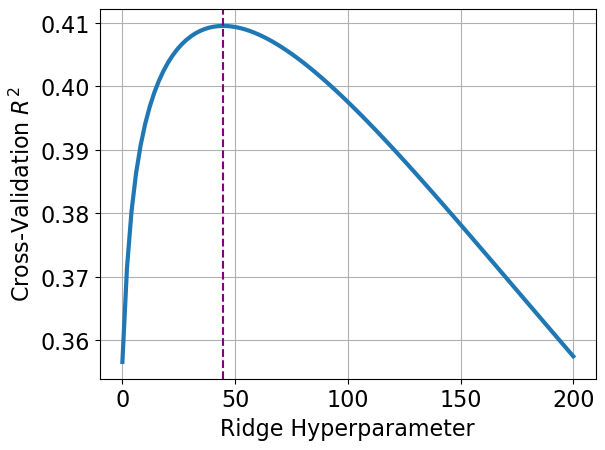

In [9]:
plt.plot(np.array(ridge_cv.cv_results_['param_alpha']) , np.array(ridge_cv.cv_results_['mean_test_score']), linewidth=3)
plt.axvline(ridge_cv.best_estimator_.alpha, color='purple', linestyle='--')
plt.xlabel("Ridge Hyperparameter")
plt.ylabel("Cross-Validation $R^2$")
plt.grid()

In [10]:
ridge_cv.best_estimator_.alpha / n

0.0611340363854501

In [11]:
ridge_muhat = ridge_cv.best_estimator_

## lasso outcome model w/ cv

In [12]:
lasso_params = {'alpha':np.linspace(1e-10, 200, 10000)}
lasso_cv = GridSearchCV(Lasso(max_iter=2000, fit_intercept=False), param_grid=lasso_params,cv=3).fit(Xpc, ypc)

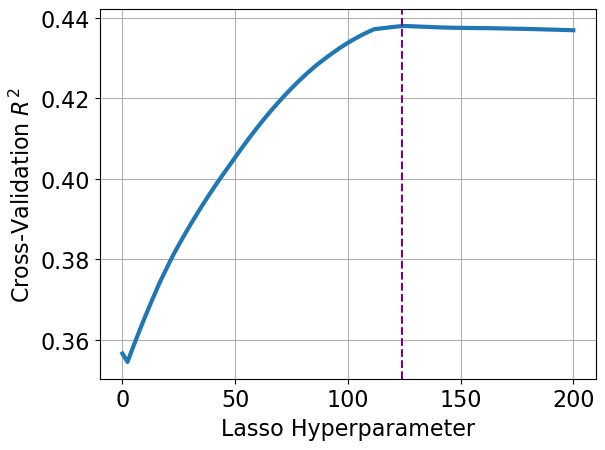

In [13]:
plt.plot(np.array(lasso_cv.cv_results_['param_alpha']) , np.array(lasso_cv.cv_results_['mean_test_score']), linewidth=3)
plt.axvline(lasso_cv.best_estimator_.alpha, color='purple', linestyle='--')
plt.xlabel("Lasso Hyperparameter")
plt.ylabel("Cross-Validation $R^2$")
plt.grid()

In [14]:
lasso_muhat = lasso_cv.best_estimator_

In [15]:
betaols = np.linalg.pinv(Xpc.T@Xpc)@Xpc.T@ypc

In [16]:
Xqc = (Xq - Xp.mean(axis=0))
Xqb = Xq.mean(axis=0)
Xqcb = Xqc.mean(axis=0)

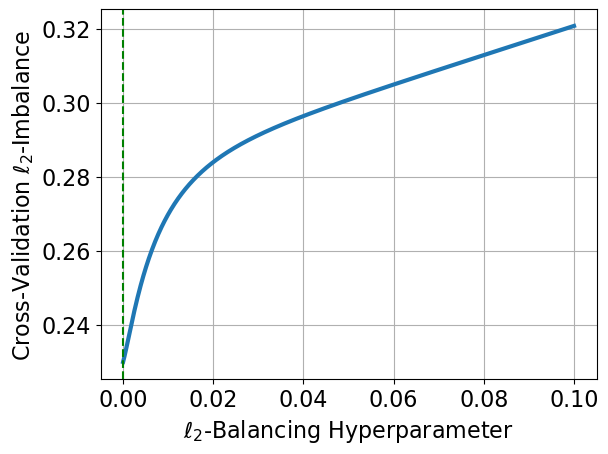

In [17]:
deltas = np.linspace(0,0.1,1000)
imbals = hyperparam.cross_val_bal_solver(Xqcb, Xp, repeats=1, seed=6401433, plot=True, plot_deltas=deltas)

plt.plot(deltas, imbals, linewidth=3)

ridge_bal_zero_cv = deltas[np.argmin(imbals)]

plt.axvline(ridge_bal_zero_cv, color='green', linestyle='--')
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation $\ell_2$-Imbalance")
plt.grid()

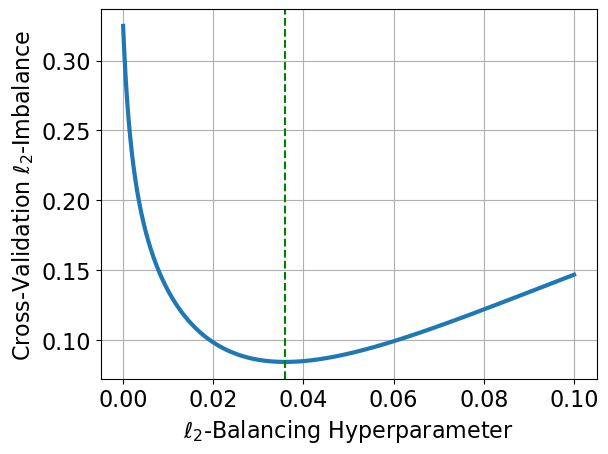

In [18]:
imbals = hyperparam.cross_val_bal_solver(Xqcb, Xp, repeats=1, plot=True, seed=220, plot_deltas=deltas)

ridge_bal_cv = deltas[np.argmin(imbals)]

plt.plot(deltas, imbals, linewidth=3)
plt.axvline(ridge_bal_cv, color='green', linestyle='--')
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation $\ell_2$-Imbalance")
plt.grid()

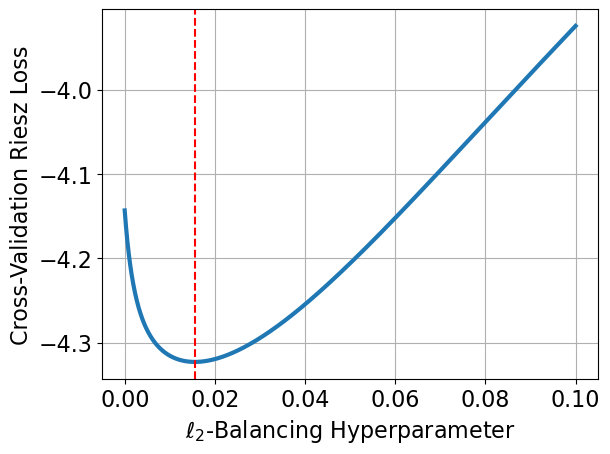

In [19]:
auto_losses = hyperparam.cross_val_autodml_solver(Xqcb, Xp, repeats=1, plot=True, seed=1, plot_deltas=deltas)

ridge_auto_cv = deltas[np.argmin(auto_losses)]

plt.plot(deltas, auto_losses, linewidth=3)
plt.axvline(ridge_auto_cv, color='red', linestyle='--')
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation Riesz Loss")
plt.grid()

In [20]:
bal_deltas_noc = hyperparam.cross_val_bal_solver(Xqb, Xp, repeats=2000)
auto_deltas_noc = hyperparam.cross_val_autodml_solver(Xqb, Xp, repeats=2000)

In [21]:
print( (np.array(bal_deltas_noc)==0).sum() )
print( (np.array(bal_deltas_noc)<=1e-4).sum() )
print( (np.array(bal_deltas_noc)<=1e-3).sum() )
print( (np.array(bal_deltas_noc)<=1e-2).sum() )
print( (np.array(bal_deltas_noc)<=1e-1).sum() )

47
48
64
205
1440


In [22]:
print( (np.array(auto_deltas_noc)==0).sum() )
print( (np.array(auto_deltas_noc)<=1e-4).sum() )
print( (np.array(auto_deltas_noc)<=1e-3).sum() )
print( (np.array(auto_deltas_noc)<=1e-2).sum() )
print( (np.array(auto_deltas_noc)<=1e-1).sum() )

0
0
0
375
2000


Text(0.5, 0, 'Cross-validated Balance Hyperparameter')

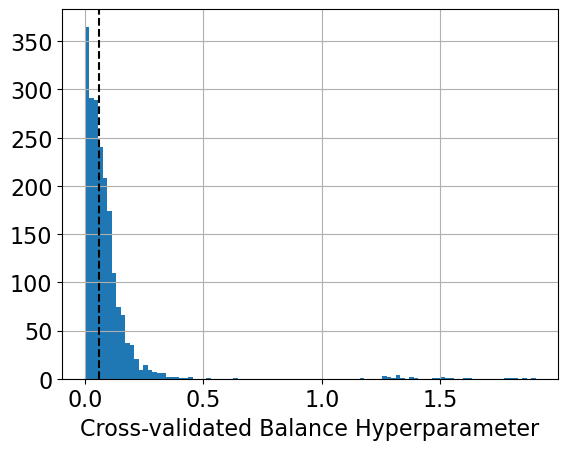

In [23]:
plt.hist(bal_deltas_noc, bins=100);
plt.axvline(np.quantile(bal_deltas_noc, 0.5), color='black', linestyle='--')
plt.grid()
plt.xlabel("Cross-validated Balance Hyperparameter")

Text(0.5, 0, 'Cross-validated Riesz Loss Hyperparameter')

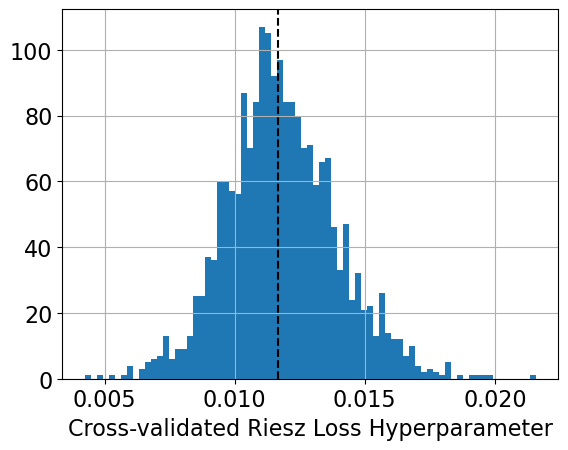

In [24]:
plt.hist(auto_deltas_noc, bins=75);
plt.axvline(np.quantile(auto_deltas_noc, 0.5), color='black', linestyle='--')
plt.grid()
plt.xlabel("Cross-validated Riesz Loss Hyperparameter")

In [25]:
bal_deltas = hyperparam.cross_val_bal_solver(Xqcb, Xp, repeats=2000)
auto_deltas = hyperparam.cross_val_autodml_solver(Xqcb, Xp, repeats=2000)

Text(0.5, 0, 'Cross-validated Balance Hyperparameter')

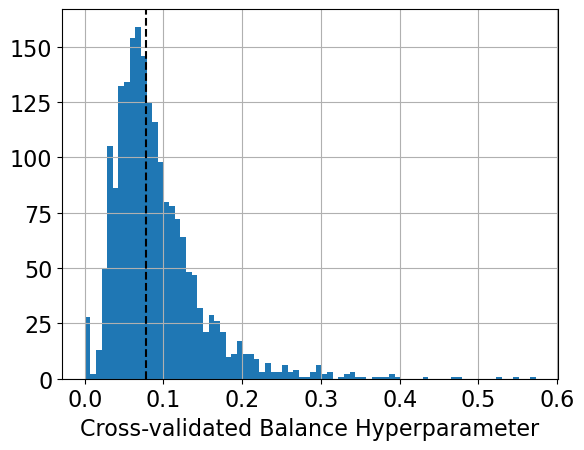

In [26]:
plt.hist(bal_deltas, bins=80);
plt.axvline(np.quantile(bal_deltas, 0.5), color='black', linestyle='--')
plt.grid()
plt.xlabel("Cross-validated Balance Hyperparameter")

In [27]:
(np.array(bal_deltas) <= 1e-10).sum()

25

Text(0.5, 0, 'Cross-validated Riesz Loss Hyperparameter')

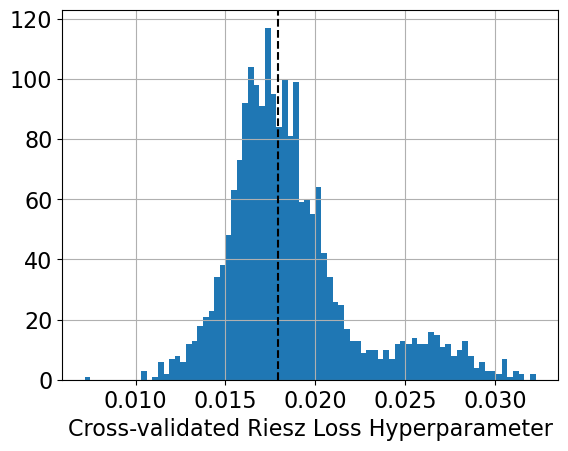

In [28]:
plt.hist(auto_deltas, bins=80);
plt.axvline(np.quantile(auto_deltas, 0.5), color='black', linestyle='--')
plt.grid()
plt.xlabel("Cross-validated Riesz Loss Hyperparameter")

# Check Linf balance

In [29]:
def MDL(delta,sigmahat,Xq):

    M=sigmahat.shape[1]

    rho = cp.Variable(M)

    prob = cp.Problem(cp.Minimize( cp.quad_form(rho, sigmahat) - 2*rho@Xq + delta*cp.norm(rho,1) ))
    
    optimal_value = prob.solve(solver='ECOS', max_iters=5000, reltol=1e-15, abstol=1e-15, feastol=1e-15)
    return(rho.value)

In [30]:
deltas = np.linspace(0,0.4,300)
# deltas = np.linspace(0,0.4,300)

ks = 5
kf = KFold(n_splits=ks, shuffle=True, random_state=2) 
all_losses = []
all_thetas = []
all_imbals = []
for i, (train_index, test_index) in enumerate(kf.split(Xp)):
    trainMean = Xp[train_index, :].mean(axis=0)
    Xtrain = Xp[train_index, :] - trainMean
    Xtest = Xp[test_index, :] - trainMean

    nt = Xtrain.shape[0]
    
    thetas = []
    losses = []
    imbals = []
    for delta in deltas:
        theta = MDL(delta, Xtrain.T@Xtrain/n, Xqcb)

        theta[np.abs(theta) < 1e-10] = 0

        loss = hyperparam.autodml_loss(theta, Xtest, Xqcb)
        imbal = hyperparam.calc_imbal(theta, Xtest, Xqcb)
        thetas.append( theta )
        losses.append(loss)
        imbals.append(imbal)

    all_losses.append(losses)
    all_thetas.append(thetas)
    all_imbals.append(imbals)

cv_dels = deltas[np.argmin(np.array(all_losses).mean(axis=0))]
bal_dels = deltas[np.argmin(np.array(all_imbals).mean(axis=0))]

c:\Users\david\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


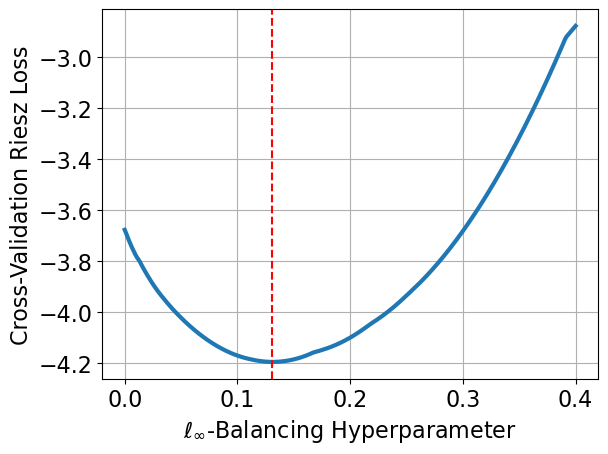

In [31]:
avg_losses = np.array(all_losses).mean(axis=0)

plt.plot(deltas, avg_losses, linewidth=3)

lasso_auto_cv = deltas[np.argmin(avg_losses)]

plt.axvline(lasso_auto_cv, color='red', linestyle='--')
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation Riesz Loss")
plt.grid()

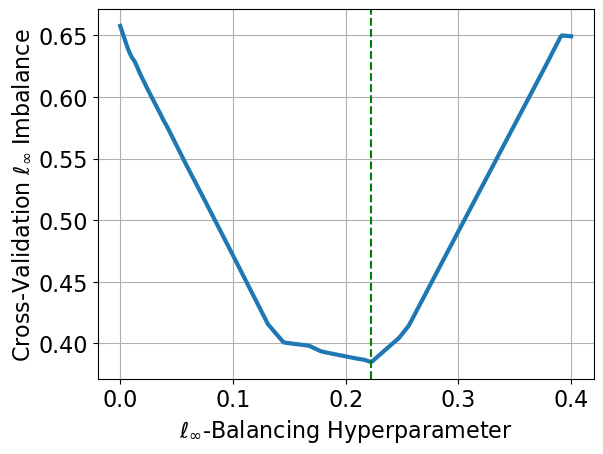

In [32]:
avg_imbals = np.array(all_imbals).mean(axis=0)

plt.plot(deltas, avg_imbals, linewidth=3)

lasso_bal_cv = deltas[np.argmin(avg_imbals)]

plt.axvline(lasso_bal_cv, color='green', linestyle='--')
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation $\ell_\infty$ Imbalance")

plt.grid()

### plot sweep of final augmented point estimates

In [33]:
betahat = ridge_muhat.coef_
deltas = np.linspace(0, 1, 100)
aug_points = []
for delta in deltas:
    rhohat = np.linalg.inv(Xpc.T@Xpc/n + delta*np.eye(Xpc.shape[1])) @ Xqcb
    what = Xpc@rhohat/n

    aug = Xqcb@betahat + what@(ypc - Xpc@betahat)
    aug_points.append(aug)

Text(0, 0.5, 'Augmented Point Estimate')

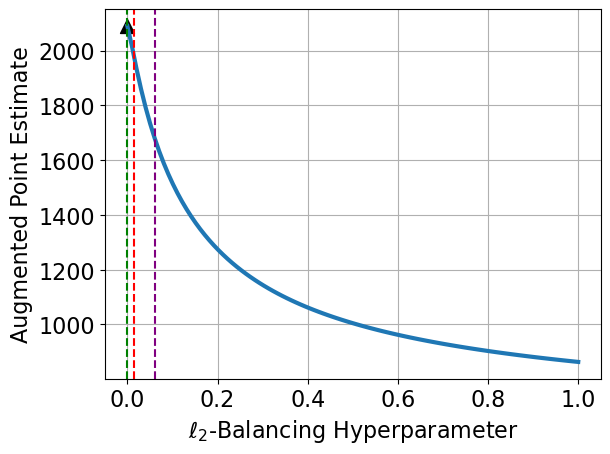

In [34]:
plt.plot(deltas,Y[T==1].mean() - (yp.mean()+np.array(aug_points)), linewidth=3)
plt.scatter(0,Y[T==1].mean() - (yp.mean()+Xqcb@betaols),color='black', marker='^', s=100)
#plt.axvline(mean_opt_delta2, color='blue', linestyle='--')
plt.axvline(ridge_muhat.alpha/n, color='purple', linestyle='--')
plt.axvline(ridge_bal_zero_cv, color='green', linestyle='--')
plt.axvline(ridge_auto_cv, color='red', linestyle='--')

plt.grid()
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Augmented Point Estimate")

In [36]:
betahat = lasso_muhat.coef_
deltas = np.linspace(0,1,300)
aug_points = []
for delta in deltas:

    theta = MDL(delta, Xpc.T@Xpc/n, Xqcb)

    theta[np.abs(theta) < 1e-10] = 0

    what = Xpc@theta/n

    aug = Xqcb@betahat + what@(ypc - Xpc@betahat)
    aug_points.append(aug)

Text(0, 0.5, 'Augmented Point Estimate')

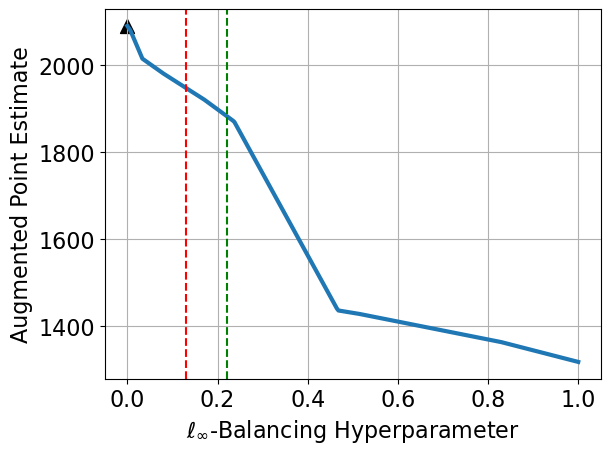

In [37]:
plt.plot(deltas,Y[T==1].mean() - (yp.mean()+np.array(aug_points)), linewidth=3)
plt.scatter(0,Y[T==1].mean() - (yp.mean()+Xqcb@betaols),color='black', marker='^', s=100)

plt.axvline(lasso_bal_cv, color='green', linestyle='--')
plt.axvline(lasso_auto_cv, color='red', linestyle='--')

plt.grid()
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Augmented Point Estimate")